# Behavior Cloning

### 1. Data Preprocessing( Do not run codes in the part)

    a. Image Data Normanlization
    b. Image Data Centralization
    c. Image Cropping
    d. Data Augmentation---Image Flipping

a. Image Data Normanlization<br>
b. Image Data Centralization


All the pixel values are normalized between 0 and 1 by dividing by 255.0 and mean of the values is centralized to zero.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Lambda

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

c. Image Cropping<br>
<img src="assets/original-image.jpg">
<center>Before Cropping</center>
<img src="assets/cropped-image.jpg">
<center>After Cropping</center>

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Cropping2D
import cv2

# set up cropping2D layer
model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))
#50 rows pixels from the top of the image
#20 rows pixels from the bottom of the image
#0 columns of pixels from the left of the image
#0 columns of pixels from the right of the image

d. Data Augmentation---Image Flipping

The Image is Flipped Horizontally and the angles are reversed.

In [ ]:
import numpy as np
image_flipped = np.fliplr(image)
measurement_flipped = -measurement

### 2. Model Building Pipeline

a. Reading and Visualizing Data

In [13]:
import csv
import numpy as np
import cv2
import os.path
import matplotlib.pyplot as plt
car_images = []
steering_angles = []
        
with open('./data/driving_log.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[3]=='steering':
            continue
        steering_center = [float(row[3])]

        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_center.append(steering_center[0] + correction)
        steering_center.append(steering_center[0] - correction)

        # read in images from center, left and right cameras
        path = './data/' # fill in the path to your training IMG directory
        for i in range(3):
            # remove images that don't exist
            if os.path.isfile(path + row[i].strip()):
                img = path + row[i].strip()
                # add images and angles to data set
                car_images.append(img)
                steering_angles.append(steering_center[i])

In [21]:
print('size of data = '+str(len(car_images)))
print('size of label data = '+str(len(steering_angles)))

size of data = 21921
size of label data = 21921


image shape = (160, 320, 3)
steering_angles = -0.25975719


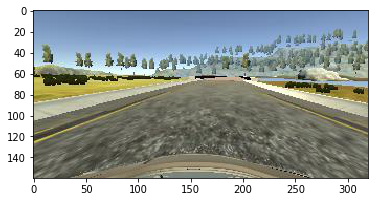

In [22]:
img = cv2.imread(car_images[139])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('image shape = '+str(img.shape))
plt.imshow(img)
print('steering_angles = '+str(steering_angles[278]))

Above: Original Image<br>
Below: Flipped Image

image shape = (160, 320, 3)
steering_angles = -0.0617599


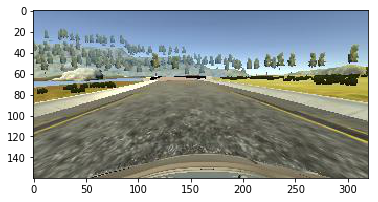

In [23]:
img = cv2.imread(car_images[139])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('image shape = '+str(img.shape))
plt.imshow(np.fliplr(img))
print('steering_angles = '+str(steering_angles[139]*-1.0))

### 3. Model Building
a. Import Packages

In [63]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, Cropping2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Lambda
from keras.models import Model, load_model
from keras import optimizers
from keras.preprocessing import image
from keras.initializers import glorot_uniform

b. Model Architecture
<img src="assets/EndtoEnd_arch.png">

In [64]:
def end_to_end(input_shape):
    X_input = Input(input_shape)
    X = Lambda(lambda x: x / 255.0 - 0.5, input_shape = input_shape)(X_input)
    X = Cropping2D(cropping=((70,25),(0,0)))(X)
    # Convolutional Layers 1
    X = Conv2D(filters=24, kernel_size=(5,5),strides=(2,2),activation='relu',kernel_initializer = glorot_uniform(seed=0))(X)
    # Convolutional Layers 2
    X = Conv2D(filters=36, kernel_size=(5,5),strides=(2,2),activation='relu',kernel_initializer = glorot_uniform(seed=0))(X)
    # Convolutional Layers 3
    X = Conv2D(filters=48, kernel_size=(5,5),strides=(2,2),activation='relu',kernel_initializer = glorot_uniform(seed=0))(X)
    # Convolutional Layers 4
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu',kernel_initializer = glorot_uniform(seed=0))(X)
    # Convolutional Layers 5
    X = Conv2D(filters=64, kernel_size=(3,3),activation='relu',kernel_initializer = glorot_uniform(seed=0))(X)
    # FC Layers
    X = Flatten()(X)
    X = Dense(100)(X)
    X = Dense(50)(X)
    X = Dense(10)(X)
    X = Dense(1)(X)
    # create model
    model = Model(inputs=X_input,output=X)
    return model

In [65]:
# build data generator
from sklearn.model_selection import train_test_split
import sklearn
from random import shuffle
from math import ceil
samples = list(zip(car_images,steering_angles))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0,num_samples,batch_size//2):
            batch_samples = samples[offset:offset+batch_size//2]
            images = []
            angles = []
            for sample in batch_samples:
                img = cv2.imread(sample[0])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ang = float(sample[1])
                images.append(img.copy())
                angles.append(ang)
                img_flip = np.fliplr(img)
                images.append(img_flip.copy())
                angles.append(ang*-1.0)
            X_train = np.array(images)
            Y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, Y_train)

In [55]:
batch_size = 128
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

input_shape = (160, 320, 3)
model = end_to_end(input_shape)
model.compile(loss='mse', optimizer='adam')
history_object  = model.fit_generator(train_generator,
            steps_per_epoch=ceil(len(train_samples)/batch_size),
            validation_data=validation_generator,
            validation_steps=ceil(len(validation_samples)/batch_size),
            epochs=10, verbose=1)

C:\Users\Baozhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="EndtoEnd", outputs=Tensor("de...)`


Epoch 1/10
137/137 [==============================] - 27s 197ms/step - loss: 0.0215 - val_loss: 0.0185
Epoch 2/10
137/137 [==============================] - 28s 207ms/step - loss: 0.0167 - val_loss: 0.0169
Epoch 3/10
137/137 [==============================] - 26s 190ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 4/10
137/137 [==============================] - 26s 187ms/step - loss: 0.0158 - val_loss: 0.0155
Epoch 5/10
137/137 [==============================] - 25s 181ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 6/10
137/137 [==============================] - 25s 184ms/step - loss: 0.0143 - val_loss: 0.0159
Epoch 7/10
137/137 [==============================] - 27s 194ms/step - loss: 0.0135 - val_loss: 0.0143
Epoch 8/10
137/137 [==============================] - 26s 193ms/step - loss: 0.0145 - val_loss: 0.0157: 2s
Epoch 9/10
137/137 [==============================] - 25s 181ms/step - loss: 0.0132 - val_loss: 0.0143
Epoch 10/10
137/137 [==============================] - 24s 178ms/step

### 4. Visualize Loss

In [56]:
### print the keys contained in the history object
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


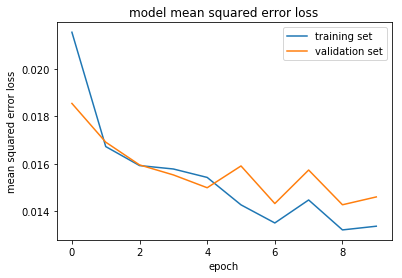

In [57]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### 5. Save Model

In [59]:
model.save('model.h5')

### 6. Load Model 

In [60]:
from keras.models import load_model
model=load_model('model.h5')

<video src="./assets/output.mp4"  controls preload></video>